# Configurações iniciais

In [ ]:
from google.colab import files
import zipfile

!pip install noisereduce
!pip install -q kaggle

# configurações do kaggle
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
with zipfile.ZipFile('gtzan-dataset-music-genre-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other


# Classificador

## Funções principais

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import noisereduce as nr
from scipy.signal import butter, filtfilt

def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=22050, duration=30)

    # plotando
    plt.figure(figsize=(14,5))
    librosa.display.waveshow(audio, sr=sr)
    plt.title('Waveform do Áudio')
    plt.xlabel('Tempo')
    plt.ylabel('Amplitude')
    plt.show()

    return audio, sr

def lowpass_filter(signal, cutoff=3000, sr=22050, order=5):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)


def preprocess_audio(audio, sr):
    audio_normalized = librosa.util.normalize(audio) # normaliza audio
    audio_normalized = lowpass_filter(audio_normalized, cutoff=3000, sr=sr) # passa num filtro passa-baixas

    # Estimativa do ruído inicial (usando os primeiros 0.5s do áudio como referência)
    noise_part = audio[:int(0.5 * sr)]

    audio_denoised = nr.reduce_noise(y=audio, sr=sr, y_noise=noise_part) # aplica Spectral Gating
    audio = librosa.util.normalize(audio_denoised)

    plt.figure(figsize=(14,5))
    librosa.display.waveshow(audio, sr=sr)
    plt.title('Waveform do áudio após pré-processamento')
    plt.xlabel('Tempo')
    plt.ylabel('Amplitude')
    plt.show()

    return audio

def extract_features(audio, sr):
    # ['perceptr_var', 'chroma_stft_mean', 'length', 'mfcc4_mean', 'spectral_bandwidth_mean', 'chroma_stft_var', 'spectral_centroid_var', 'mfcc5_var', 'mfcc8_mean', 'mfcc9_mean', 'mfcc7_var', 'label']
    perceptr_var = np.var(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20))  # Variância dos MFCCs
    chroma_stft_mean = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr))
    length = len(audio)
    mfcc4_mean = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=5)[3])  # MFCC 4
    spectral_bandwidth_mean = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr))
    chroma_stft_var = np.var(librosa.feature.chroma_stft(y=audio, sr=sr))
    spectral_centroid_var = np.var(librosa.feature.spectral_centroid(y=audio, sr=sr))
    mfcc5_var = np.var(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=6)[4])  # MFCC 5
    mfcc8_mean = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=9)[7])  # MFCC 8
    mfcc9_mean = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=10)[8])  # MFCC 9
    mfcc7_var = np.var(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=8)[6])  # MFCC 7

    return [
        perceptr_var, chroma_stft_mean, length, mfcc4_mean, spectral_bandwidth_mean,
        chroma_stft_var, spectral_centroid_var, mfcc5_var, mfcc8_mean, mfcc9_mean, mfcc7_var
    ]


## Selecionar as features mais importantes para o modelo

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd

df = pd.read_csv('/content/Data/features_30_sec.csv')

X = df.drop(columns=["filename", "label"])  # Remove a coluna do nome do arquivo e o gênero
y = df["label"]  # A variável alvo (gênero musical)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # Transforma "rock", "jazz" etc. em números

# Treinando o RandomForest
clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X, y_encoded)

# Obtendo a importância das features
importances = clf.feature_importances_
features_df = pd.DataFrame({"Feature": X.columns, "Importance": importances})

# Ordenando pela importância
features_df = features_df.sort_values(by="Importance", ascending=False)

top_features = features_df.head(20)["Feature"].values
X_reduced = X[top_features]  # Filtra apenas as 20 colunas mais importantes no dataset

print("20 Features mais importantes para o modelo: \n", features_df.head(20))

# Atualizando o dataset
df_reduced = X_reduced.copy()
df_reduced["label"] = y

df_reduced.to_csv("features_30_sec_reduced.csv", index=False)
print("\n\nNovo dataset salvo com features selecionadas!")

20 Features mais importantes para o modelo: 
                     Feature  Importance
16             perceptr_var    0.043111
1          chroma_stft_mean    0.042420
0                    length    0.041273
24               mfcc4_mean    0.032378
4                   rms_var    0.029382
3                  rms_mean    0.028296
7   spectral_bandwidth_mean    0.027133
2           chroma_stft_var    0.026891
6     spectral_centroid_var    0.024655
27                mfcc5_var    0.024101
18               mfcc1_mean    0.023724
10              rolloff_var    0.022310
32               mfcc8_mean    0.021372
14              harmony_var    0.021116
9              rolloff_mean    0.020684
28               mfcc6_mean    0.020055
5    spectral_centroid_mean    0.019338
34               mfcc9_mean    0.018896
31                mfcc7_var    0.018684
40              mfcc12_mean    0.017227


Novo dataset salvo com features selecionadas!


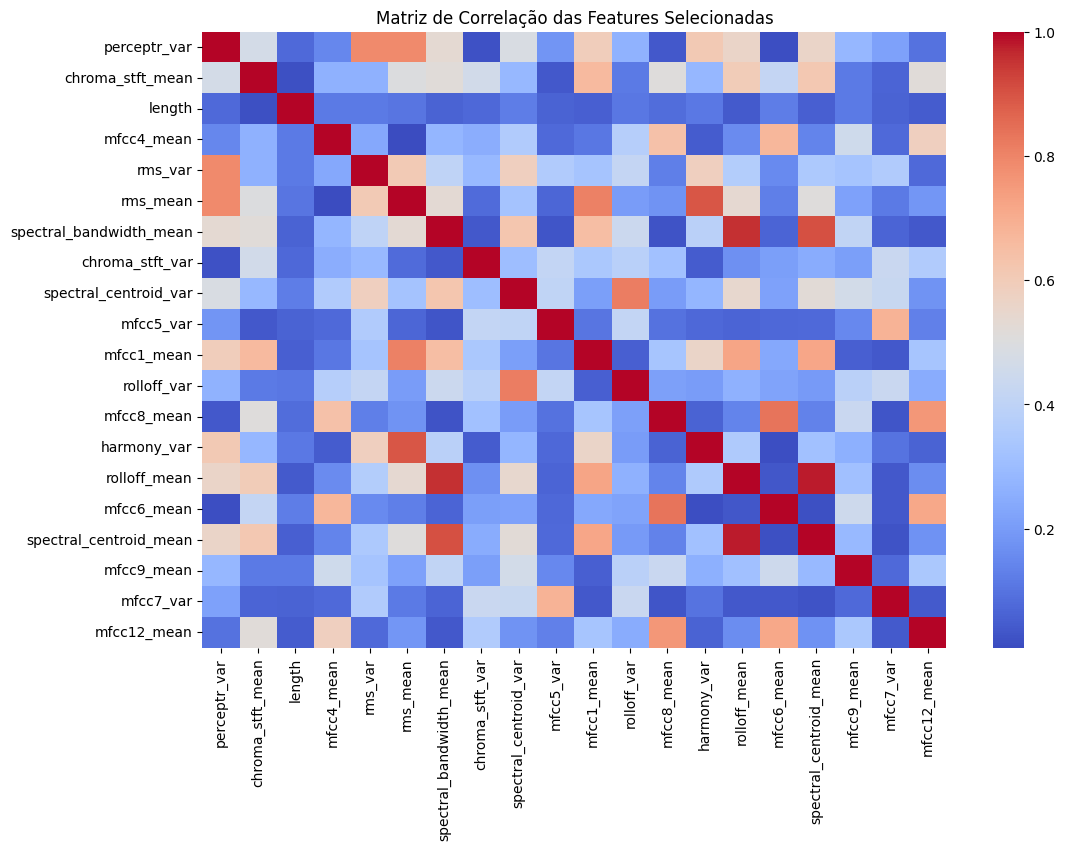

Features removidas por alta correlação: ['rms_var', 'rms_mean', 'mfcc1_mean', 'rolloff_var', 'harmony_var', 'rolloff_mean', 'mfcc6_mean', 'spectral_centroid_mean', 'mfcc12_mean']

Features mais importantes: ['perceptr_var', 'chroma_stft_mean', 'length', 'mfcc4_mean', 'spectral_bandwidth_mean', 'chroma_stft_var', 'spectral_centroid_var', 'mfcc5_var', 'mfcc8_mean', 'mfcc9_mean', 'mfcc7_var', 'label']


In [ ]:
# Dentre as 20 features, remove as que são muito correlacionadas

import seaborn as sns

df = pd.read_csv("features_30_sec_reduced.csv")

df_features = df.drop(columns=["label"])
corr_matrix = df_features.corr().abs()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Matriz de Correlação das Features Selecionadas")
plt.show()

# limite para a correlação
threshold = 0.75

upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

# Remove features correlacionadas
df_filtered = df.drop(columns=to_drop)
selected_features = df_filtered.columns.tolist()

print(f"Features removidas por alta correlação: {to_drop}")
print(f"\nFeatures mais importantes: {selected_features}")

## Modelo de classificação

aquiiiiii:  (800, 11)
Acurácia do modelo: 0.7300


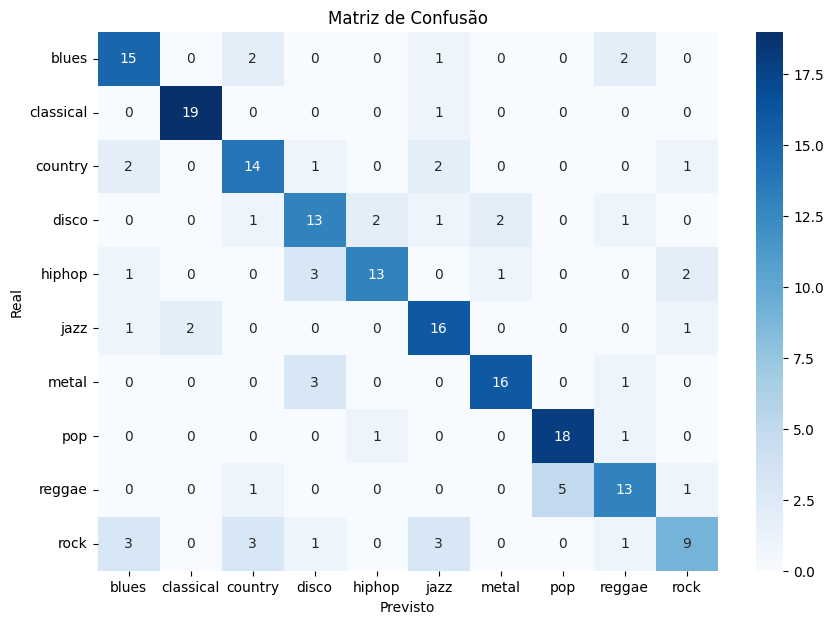


 Relatório de Classificação:
              precision    recall  f1-score   support

       blues       0.68      0.75      0.71        20
   classical       0.90      0.95      0.93        20
     country       0.67      0.70      0.68        20
       disco       0.62      0.65      0.63        20
      hiphop       0.81      0.65      0.72        20
        jazz       0.67      0.80      0.73        20
       metal       0.84      0.80      0.82        20
         pop       0.78      0.90      0.84        20
      reggae       0.68      0.65      0.67        20
        rock       0.64      0.45      0.53        20

    accuracy                           0.73       200
   macro avg       0.73      0.73      0.73       200
weighted avg       0.73      0.73      0.73       200



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Remove linhas com valores NaN (caso algum arquivo tenha falhado ao carregar)
df = df_filtered.dropna()

selected_features = [feature for feature in selected_features if feature != "label"]

X = df[selected_features]
y = df["label"]

# Divide os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Cria o classificador Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("aquiiiiii: ", X_train.shape)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {accuracy:.4f}")

# matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

print("\n Relatório de Classificação:")
print(classification_report(y_test, y_pred))

## Testa o modelo com músicas inseridas

Saving our-memories-313882.mp3 to our-memories-313882 (2).mp3


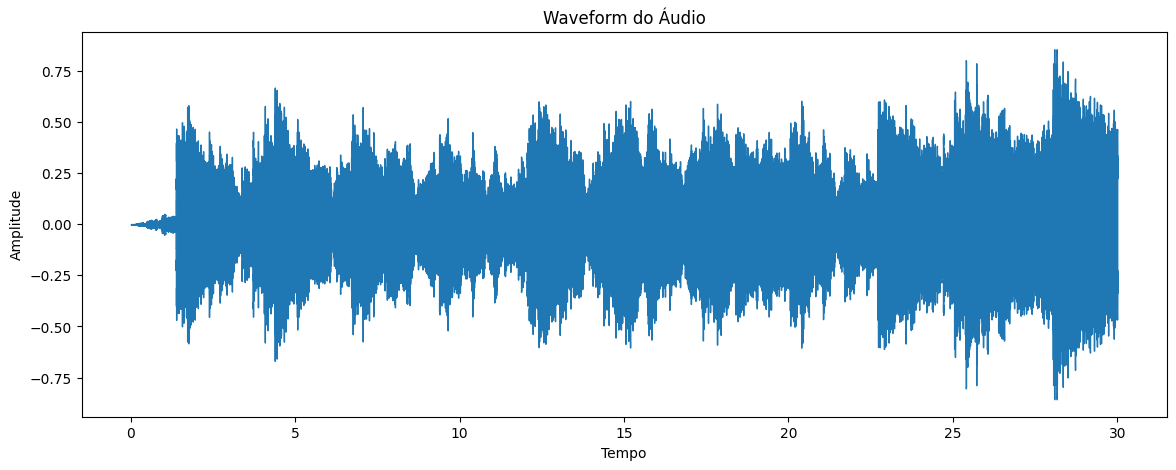

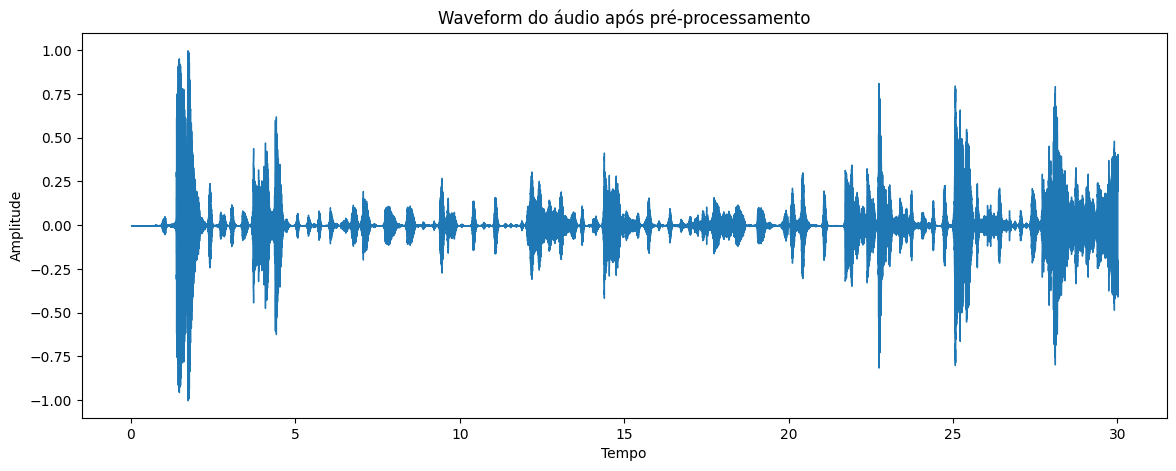

Predição do modelo: pop


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
import librosa
import numpy as np
import pandas as pd
import io
import IPython.display as ipd
from google.colab import files

uploaded = files.upload()
file_path = list(uploaded.keys())[0]

# Carrega e processar o áudio
audio, sr = load_audio(io.BytesIO(uploaded[file_path]))
audio_clean = preprocess_audio(audio, sr)
features_test = extract_features(audio_clean, sr)

# Faz a predição
prediction = clf.predict([features_test])
print(f"Predição do modelo: {prediction[0]}")